In [1]:
import sys
import pyMOPS

In [2]:
print("Available API:", dir(pyMOPS))
print("\n\n")

Available API: ['AttributeFormat', 'AttributeType', 'CalcAttributeType', 'CalcPositionType', 'CartesianCoord', 'GridAttributeType', 'MOPS_ActiveAttribute', 'MOPS_AddAttribute', 'MOPS_AddGridMesh', 'MOPS_Begin', 'MOPS_End', 'MOPS_GenerateSamplePoints', 'MOPS_Init', 'MOPS_RunRemapping', 'MOPS_RunStreamLine', 'MPASOGrid', 'MPASOSolution', 'SamplingSettings', 'SaveType', 'TrajectoryLine', 'TrajectorySettings', 'VisualizationSettings', 'VisualizeType', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'pyMOPS']





In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
input_yaml = "./mpas.yaml"
timestep = 0
ONE_HOUR = 3600
ONE_MONTH = 3600 * 24 * 30

### Utils functions used for visualization

In [28]:
def Vis_Remapping_Image(imgs, output_file="remapping.png", extent=[-180, 180, -90, 90]):
    if not imgs or len(imgs) < 2:
        raise ValueError("imgs must be a list of at least 2 images")
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axs = axes.flatten()
    
    titles = [
        "Zonal Velocity",
        "Meridional Velocity",
        "Velocity Magnitude",
        "Temperature",
        "Salinity",
        "Unused"
    ]
    
    cmaps = [
        "coolwarm", "coolwarm", "coolwarm",
        "ocean", "ocean", None
    ]
    
    data_refs = [
        imgs[0][:, :, 0],
        imgs[0][:, :, 1],
        imgs[0][:, :, 2],
        imgs[1][:, :, 0],
        imgs[1][:, :, 1],
        None  
    ]

    for i, (ax, title, data) in enumerate(zip(axs, titles, data_refs)):
        if data is not None:
            cmap = plt.get_cmap(cmaps[i]).copy()
            cmap.set_bad(color='yellow')

            im = ax.imshow(data, cmap=cmap, extent=extent,  aspect='auto')
            ax.set_title(title)
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()

In [6]:
def xyz_to_latlon(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    r = np.where(r < 1e-8, np.nan, r)
    lat = np.arcsin(z / r) * 180 / np.pi
    lon = np.arctan2(y, x) * 180 / np.pi
    return lat, lon

In [33]:
def Vis_Seeds_Image(points, save_path="sample_seeds.png"):
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    lats, lons = xyz_to_latlon(x, y, z)   

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_global()
    ax.stock_img()  
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)
    
    ax.scatter(lons, lats, color='red', s=1, transform=ccrs.PlateCarree())
    ax.set_title("Sample Seeds on Earth Map (Cartopy)")

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [35]:
def Vis_StreamLine_Image(trajectory_lines, save_path="trajectories.png"):
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)

    for line_array in trajectory_lines:
        lats, lons = [], []
        for pt in line_array:
            lat, lon = xyz_to_latlon(pt[0], pt[1], pt[2])
            if np.isnan(lon) or np.isnan(lat):
                continue
            lats.append(lat)
            lons.append(lon)
            
        if len(lons) >= 2: 
            ax.plot(lons, lats, linewidth=0.8)

    plt.title("2D Trajectories (Lat/Lon)")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## 1. Initialize the GPU environment and read the data

In [9]:
pyMOPS.MOPS_Init("gpu")
gridMesh = pyMOPS.MPASOGrid()
gridMesh.init_from_yaml(input_yaml)
attributes = pyMOPS.MPASOSolution()
attributes.init_from_yaml(input_yaml, timestep)
attributes.add_attribute("temperature", pyMOPS.AttributeFormat.kFloat)
attributes.add_attribute("salinity", pyMOPS.AttributeFormat.kFloat)

 [ system information ]
Device selected : NVIDIA A100-PCIE-40GB
Device vendor   : NVIDIA Corporation
Device version  : 8.0
09:18:12 [DEBUG]  [Data]::Created directory: ./.data/output1
09:18:12 [DEBUG]  [MPASOReader]::loading mCellsSize        = 	 [ 235160 ]
09:18:12 [DEBUG]  [MPASOReader]::loading mEdgesSize        = 	 [ 714274 ]
09:18:12 [DEBUG]  [MPASOReader]::loading mMaxEdgesSize     = 	 [ 7 ]
09:18:12 [DEBUG]  [MPASOReader]::loading mVertexSize       = 	 [ 478835 ]
09:18:12 [DEBUG]  [Ndarray]::loading cellCoord_vec                  = 	 [ 235160   ] 	 type = [ float64    float64    float64    ]
09:18:12 [DEBUG]  [Ndarray]::loading vertexCoord_vec                = 	 [ 478835   ] 	 type = [ float64    float64    float64    ]
09:18:12 [DEBUG]  [Ndarray]::loading edgeCoord_vec                  = 	 [ 714274   ] 	 type = [ float64    float64    float64    ]
09:18:12 [DEBUG]  [Ndarray]::loading verticesOnCell                 = 	 [ 1646120  ] 	 type = [ int32      ]
09:18:12 [DEBUG]  [Ndar

input substream 'mesh', filename_pattern=/pscratch/sd/q/qiuyf/dataset/output1.nc, found 1 files.
filename=/pscratch/sd/q/qiuyf/dataset/output1.nc, nt=30
input substream 'data', filename_pattern=/pscratch/sd/q/qiuyf/dataset/output1.nc, found 1 files.
filename=/pscratch/sd/q/qiuyf/dataset/output1.nc, nt=30
input substream 'mesh', filename_pattern=/pscratch/sd/q/qiuyf/dataset/output1.nc, found 1 files.
filename=/pscratch/sd/q/qiuyf/dataset/output1.nc, nt=30
input substream 'data', filename_pattern=/pscratch/sd/q/qiuyf/dataset/output1.nc, found 1 files.
filename=/pscratch/sd/q/qiuyf/dataset/output1.nc, nt=30


ray]::loading verticesOnEdge                 = 	 [ 1428548  ] 	 type = [ int32      ]
09:18:12 [DEBUG]  [Ndarray]::loading cellsOnVertex                  = 	 [ 1436505  ] 	 type = [ int32      ]
09:18:12 [DEBUG]  [Ndarray]::loading cellsOnCell                    = 	 [ 1646120  ] 	 type = [ int32      ]
09:18:12 [DEBUG]  [Ndarray]::loading nEdgesOnCell                   = 	 [ 235160   ] 	 type = [ int32      ]
09:18:12 [DEBUG]  [Ndarray]::loading cellsOnEdge                    = 	 [ 1428548  ] 	 type = [ int32      ]
09:18:12 [DEBUG]  [Ndarray]::loading edgesOnCell                    = 	 [ 1646120  ] 	 type = [ int32      ]
          [ timestep = 0 ]
====== bottomDepth found [✓]
09:18:14 [DEBUG]  [Ndarray]::loading bottomDepth_vec = 	 [ 235160   ] 	 type = [ float64    ]
====== velocityZonal found [✓]
09:18:14 [DEBUG]  [Ndarray]::loading velocityZonal_vec = 	 [ 14109600 ] 	 type = [ float64    ]
====== velocityMeridional found [✓]
09:18:14 [DEBUG]  [Ndarray]::loading velocityMeridional_

## 2. Load data into the MOPS environment

In [10]:
pyMOPS.MOPS_Begin()
pyMOPS.MOPS_AddGridMesh(gridMesh)
pyMOPS.MOPS_AddAttribute(timestep, attributes)
pyMOPS.MOPS_End()

09:18:15 [DEBUG]  [Ndarray]::loading salinity  _vec = 	 [ 14109600 ] 	 type = [ float64    ]
09:18:22 [DEBUG]  [MPASOGrid]::Create KD Tree...
09:18:22 [DEBUG]  [MPASOGrid]::Saved KD Tree in [ ./.data/output1/KDTree.bin ]
 [✓]finished loading grid information
09:18:22 [DEBUG]  [MPASOSolution]::Calc Cell Center Z Top at t = 0
 [ Run calcCellVertexZtop ]
Wrote 28730100 elements to ./.data/output1/cellVertexZTop_vec_0.bin
09:18:25 [DEBUG]  [MPASOSolution]::Calc Cell Vertex Z Top  = 	 [ 28730100 ] 	 type = [ float64 ]
 [ Run calcCellCenterVelocity ]
Wrote 14109600 elements to ./.data/output1/cellCenterVelocity_vec_0.bin
09:18:26 [DEBUG]  [MPASOSolution]::Calc Cell VcellCenterVelocity_vec  = 	 [ 14109600 ] 	 type = [ float64 float64 float64]
 [ Run calcCellVertexVelocity ]
Wrote 28730100 elements to ./.data/output1/cellVertexVelocity_vec_0.bin
09:18:28 [DEBUG]  [MPASOSolution]::Calc Cell cellVertexVelocity_vec  = 	 [ 28730100 ] 	 type = [ float64 float64 float64]
 [ Run calcCellCenterToVerte

## Function 1: Remapping

In [11]:
pyMOPS.MOPS_ActiveAttribute(timestep)
config = pyMOPS.VisualizationSettings()
config.imageSize = (3601, 1801)
config.LatRange = (-90, 90)
config.LonRange = (-180, 180)
config.FixedDepth = 10.0
config.TimeStep = timestep

In [12]:
imgs = pyMOPS.MOPS_RunRemapping(config)

 [ Run remapping  ]
09:18:38 [DEBUG]  [MPASOVisualizer]::Finished KD Tree Search....
09:18:58 [DEBUG]  [VTKFileManager]::Saved multi-attribute VTI to 0_0_fixed_depth_10.000000.vti
 ==== [✓] done...


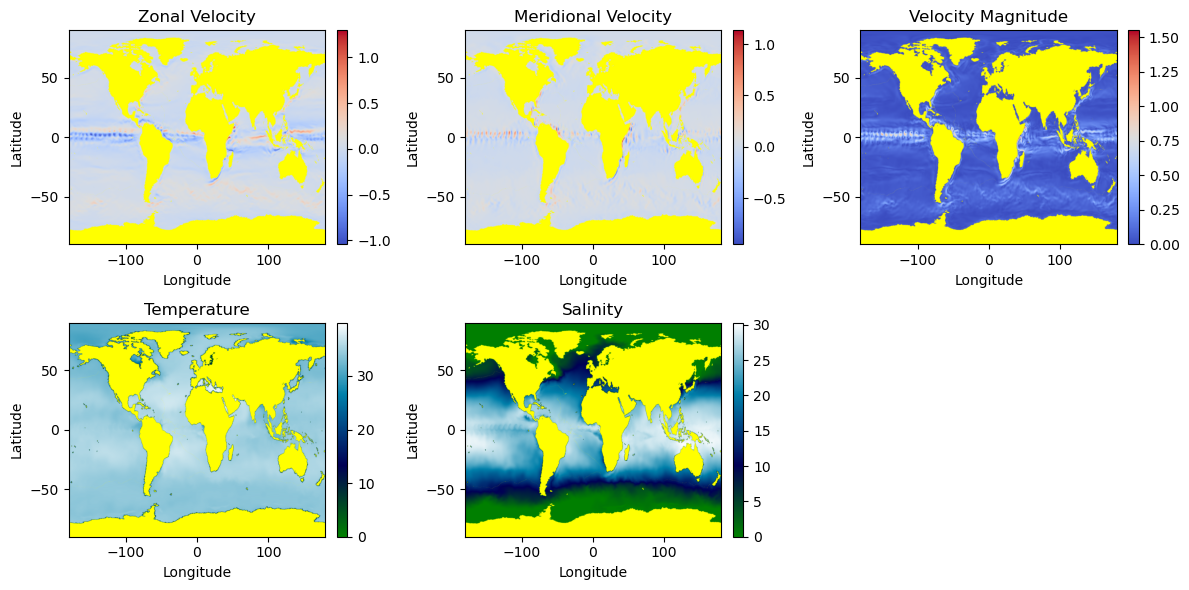

In [29]:
Vis_Remapping_Image(imgs)

## Function 1: Remap in different geographical areas

In [30]:
config = pyMOPS.VisualizationSettings()
config.imageSize = (3601, 1801)
config.LatRange = (20, 60)
config.LonRange = (-60, -20)
config.FixedDepth = 10.0
config.TimeStep = timestep

In [31]:
imgs = pyMOPS.MOPS_RunRemapping(config)

 [ Run remapping  ]
09:25:27 [DEBUG]  [MPASOVisualizer]::Finished KD Tree Search....
09:25:53 [DEBUG]  [VTKFileManager]::Saved multi-attribute VTI to 0_0_fixed_depth_10.000000.vti
 ==== [✓] done...


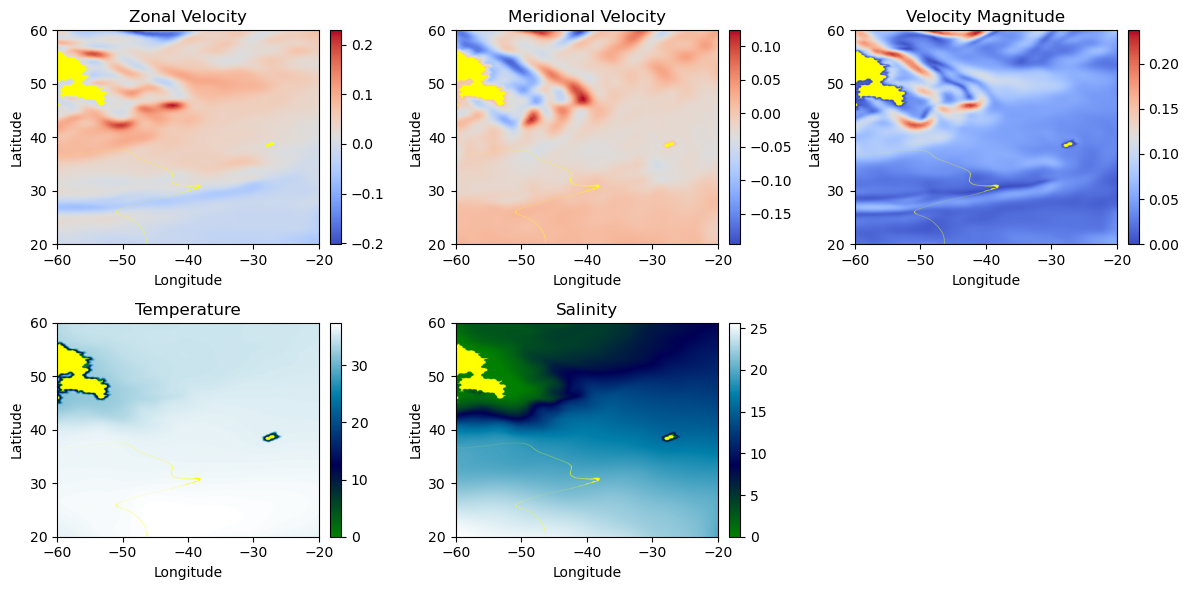

In [32]:
Vis_Remapping_Image(imgs, extent = [-60, -20, 20, 60])

## Function 2: Seed generation in the designated area

In [21]:
conf = pyMOPS.SamplingSettings()
conf.setSeedsRange((31, 31))  
conf.setGeoBox((35.0, 45.0), (-90.0, -45.0)) 
conf.setDepth(10.0)

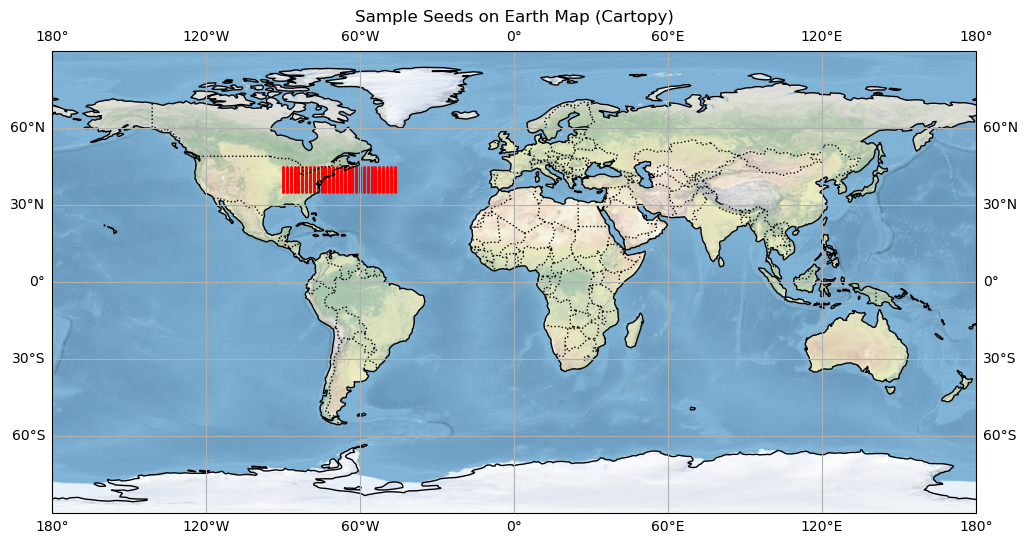

In [34]:
sample_pts = pyMOPS.MOPS_GenerateSamplePoints(conf)  # output: np.ndarray
Vis_Seeds_Image(sample_pts)

## Function 3：Stream Lines

In [23]:
traj_conf = pyMOPS.TrajectorySettings()
traj_conf.depth = conf.getDepth()
traj_conf.deltaT = ONE_HOUR
traj_conf.simulationDuration = ONE_MONTH * 2
traj_conf.recordT = ONE_HOUR * 1    

09:27:43 [DEBUG]  Generate 900 sample points in [ 35.000000, -90.000000 ] -> [ 45.000000, -45.000000 ]
points.size = 900, default_cell_id.size = 900
09:28:51 [DEBUG]  [VisualizeTrajectory]::Finished...
 ==== [✓] done...


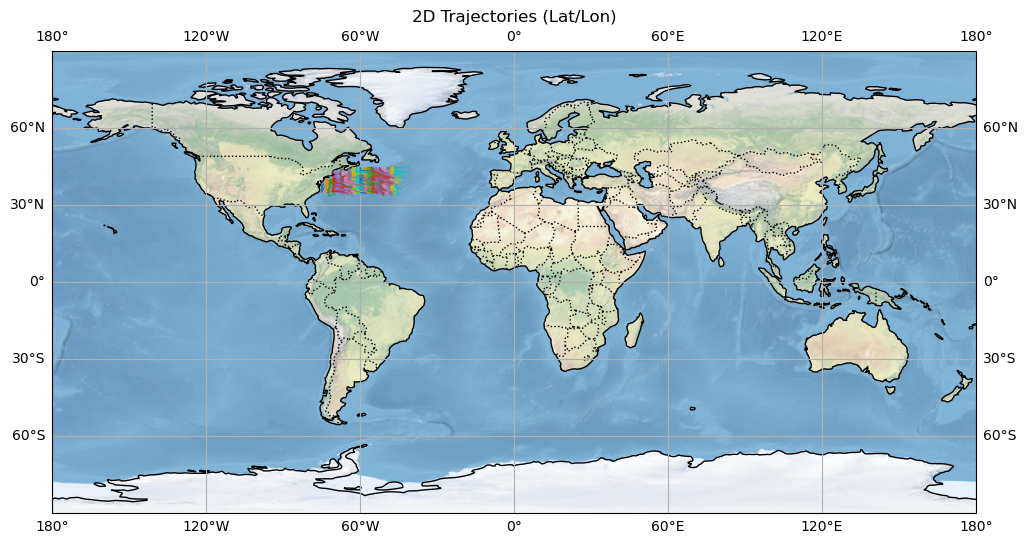

In [36]:
lines = pyMOPS.MOPS_RunStreamLine(traj_conf, sample_pts) 
Vis_StreamLine_Image(lines)